### TFG - Cesar Hernandez Rodriguez
Quintos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores de cierre de diferentes activos. Este script es una ema de lo que se busca en el TFG, tiene limitacion de activos de los cuales todos se predicen de una forma correcta con minimo 200 epocas.

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['IIIN', 'PRGX', 'UNFI', 'EBIO', 'MINI', 'SNCR', 'USAP', 'JMBA', 'NTLS', 'FDML', 'PTIE']$ de los cuales $NTLS$ no cumple la condicion de que tenga datos para el test en las fechas deseadas y $FDML$ tiene pocos datos para el conjunto test

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

Using TensorFlow backend.


In [2]:
# Tengo dos .csv con todos los tickers que me guarda la API de Quandl y en otro con los tickers que quiero usar
# para esta demo, comparo si estan todos y los pongo en formato de descarga (WIKI/ticker)
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-funciona.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [238]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [59]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [239]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  18.181818181818183 % de los datos
LLeva descargados el  36.36363636363637 % de los datos
LLeva descargados el  54.54545454545454 % de los datos
LLeva descargados el  72.72727272727273 % de los datos
LLeva descargados el  90.9090909090909 % de los datos

Ha tardado en descargar los datos: 18.7667257786 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  18.181818181818183 % de los datos test
LLeva descargados el  36.36363636363637 % de los datos test
LLeva descargados el  54.54545454545454 % de los datos test
LLeva descargados el  72.72727272727273 % de los datos test
LLeva descargados el  90.9090909090909 % de los datos test

Ha tardado en descargar los datos test: 9.9525628090 segundos.


Restriccion de longitud NTLS
Restriccion de longitud FDML


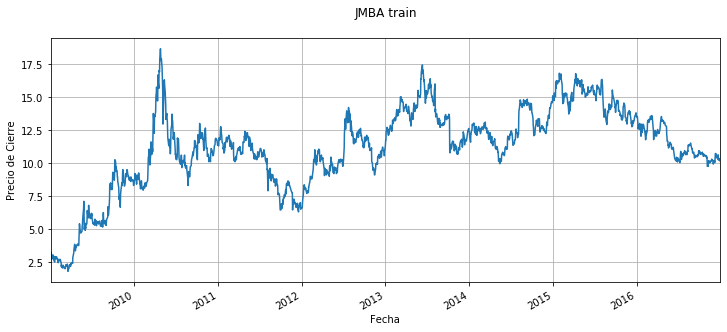

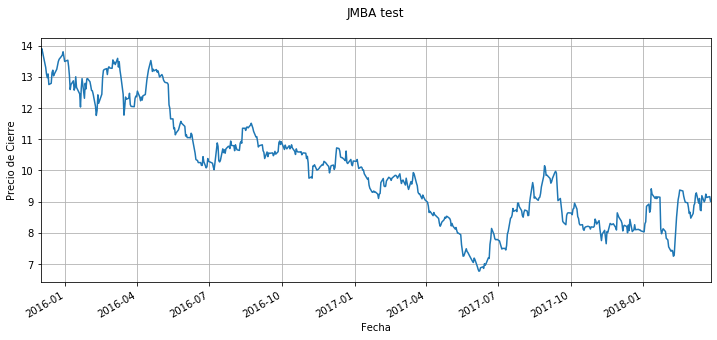

In [240]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [81]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [247]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],10,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo ",ticket_uso)

Voy a predecir el activo  JMBA


In [250]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [251]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model.add(LSTM(units = 5,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
lstm_14 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________


In [252]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 1160 samples, validate on 581 samples
Epoch 1/1500
1160/1160 [==============================] - 15s 13ms/step - loss: 141.7129 - porcentaje_margen: 0.0000e+00 - val_loss: 139.7163 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 128.8533 - porcentaje_margen: 0.0000e+00 - val_loss: 125.4562 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
1160/1160 [==============================] - 13s 12ms/step - loss: 116.8452 - porcentaje_margen: 0.0000e+00 - val_loss: 115.1284 - val_porcentaje_margen: 0.0000e+00
Epoch 4/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 108.0059 - porcentaje_margen: 0.0000e+00 - val_loss: 107.3369 - val_porcentaje_margen: 0.0000e+00
Epoch 5/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 100.9998 - porcentaje_margen: 0.0000e+00 - val_loss: 100.8142 - val_porcentaje_margen: 0.0000e+00
Epoch 6/1500
1160/1160 [==============================] - 12s 1

1160/1160 [==============================] - 14s 12ms/step - loss: 10.8558 - porcentaje_margen: 0.0633 - val_loss: 11.3111 - val_porcentaje_margen: 0.0747
Epoch 49/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 10.3691 - porcentaje_margen: 0.0853 - val_loss: 10.7971 - val_porcentaje_margen: 0.0895
Epoch 50/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 9.9118 - porcentaje_margen: 0.0988 - val_loss: 10.3326 - val_porcentaje_margen: 0.1043
Epoch 51/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 9.4855 - porcentaje_margen: 0.1208 - val_loss: 9.8896 - val_porcentaje_margen: 0.1125
Epoch 52/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 9.0918 - porcentaje_margen: 0.1284 - val_loss: 9.4774 - val_porcentaje_margen: 0.1273
Epoch 53/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 8.7267 - porcentaje_margen: 0.1478 - val_loss: 9.0981 - val_porcentaje_margen: 0.1388
Epoch 5

1160/1160 [==============================] - 14s 12ms/step - loss: 5.0165 - porcentaje_margen: 0.1976 - val_loss: 4.9781 - val_porcentaje_margen: 0.2135
Epoch 98/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 5.0152 - porcentaje_margen: 0.1926 - val_loss: 4.9743 - val_porcentaje_margen: 0.2118
Epoch 99/1500
1160/1160 [==============================] - 13s 12ms/step - loss: 5.0143 - porcentaje_margen: 0.1909 - val_loss: 4.9716 - val_porcentaje_margen: 0.2036
Epoch 100/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 5.0138 - porcentaje_margen: 0.1959 - val_loss: 4.9664 - val_porcentaje_margen: 0.2086
Epoch 101/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 5.0128 - porcentaje_margen: 0.1909 - val_loss: 4.9656 - val_porcentaje_margen: 0.2086
Epoch 102/1500
1160/1160 [==============================] - 14s 12ms/step - loss: 5.0125 - porcentaje_margen: 0.1909 - val_loss: 4.9621 - val_porcentaje_margen: 0.2086
Epoch 103

Epoch 146/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0111 - porcentaje_margen: 0.1934 - val_loss: 4.9515 - val_porcentaje_margen: 0.2118
Epoch 147/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0109 - porcentaje_margen: 0.1909 - val_loss: 4.9499 - val_porcentaje_margen: 0.2086
Epoch 148/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0113 - porcentaje_margen: 0.1959 - val_loss: 4.9501 - val_porcentaje_margen: 0.2086
Epoch 149/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0110 - porcentaje_margen: 0.1993 - val_loss: 4.9477 - val_porcentaje_margen: 0.2069
Epoch 150/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0122 - porcentaje_margen: 0.1917 - val_loss: 4.9494 - val_porcentaje_margen: 0.2086
Epoch 151/1500
1160/1160 [==============================] - 13s 11ms/step - loss: 5.0112 - porcentaje_margen: 0.1968 - val_loss: 4.9475 - val_porcentaje_margen:

Epoch 195/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.5439 - porcentaje_margen: 0.6267 - val_loss: 0.5219 - val_porcentaje_margen: 0.6451
Epoch 196/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.5340 - porcentaje_margen: 0.6377 - val_loss: 0.5130 - val_porcentaje_margen: 0.6467
Epoch 197/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.5248 - porcentaje_margen: 0.6377 - val_loss: 0.5114 - val_porcentaje_margen: 0.6286
Epoch 198/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.4996 - porcentaje_margen: 0.6554 - val_loss: 0.4991 - val_porcentaje_margen: 0.6516
Epoch 199/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.5101 - porcentaje_margen: 0.6444 - val_loss: 0.4939 - val_porcentaje_margen: 0.6484
Epoch 200/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.4827 - porcentaje_margen: 0.6807 - val_loss: 0.4799 - val_porcentaje_margen:

Epoch 244/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3750 - porcentaje_margen: 0.7221 - val_loss: 0.3525 - val_porcentaje_margen: 0.7461
Epoch 245/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3892 - porcentaje_margen: 0.7027 - val_loss: 0.4191 - val_porcentaje_margen: 0.6539
Epoch 246/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3751 - porcentaje_margen: 0.7348 - val_loss: 0.3490 - val_porcentaje_margen: 0.7296
Epoch 247/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3611 - porcentaje_margen: 0.7390 - val_loss: 0.3491 - val_porcentaje_margen: 0.7549
Epoch 248/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3800 - porcentaje_margen: 0.7314 - val_loss: 0.3568 - val_porcentaje_margen: 0.7132
Epoch 249/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3800 - porcentaje_margen: 0.7188 - val_loss: 0.3432 - val_porcentaje_margen:

Epoch 293/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3731 - porcentaje_margen: 0.7365 - val_loss: 0.3545 - val_porcentaje_margen: 0.7599
Epoch 294/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3435 - porcentaje_margen: 0.7593 - val_loss: 0.3171 - val_porcentaje_margen: 0.7592
Epoch 295/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3415 - porcentaje_margen: 0.7593 - val_loss: 0.3103 - val_porcentaje_margen: 0.7789
Epoch 296/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3368 - porcentaje_margen: 0.7508 - val_loss: 0.3133 - val_porcentaje_margen: 0.7796
Epoch 297/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.3384 - porcentaje_margen: 0.7627 - val_loss: 0.3150 - val_porcentaje_margen: 0.7592
Epoch 298/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3400 - porcentaje_margen: 0.7517 - val_loss: 0.3203 - val_porcentaje_margen:

Epoch 342/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3196 - porcentaje_margen: 0.7644 - val_loss: 0.2944 - val_porcentaje_margen: 0.8026
Epoch 343/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3362 - porcentaje_margen: 0.7466 - val_loss: 0.2920 - val_porcentaje_margen: 0.8026
Epoch 344/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3206 - porcentaje_margen: 0.7669 - val_loss: 0.2984 - val_porcentaje_margen: 0.7993
Epoch 345/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3267 - porcentaje_margen: 0.7551 - val_loss: 0.3319 - val_porcentaje_margen: 0.7148
Epoch 346/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3319 - porcentaje_margen: 0.7703 - val_loss: 0.2874 - val_porcentaje_margen: 0.8076
Epoch 347/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3169 - porcentaje_margen: 0.7644 - val_loss: 0.2872 - val_porcentaje_margen:

Epoch 391/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.3145 - porcentaje_margen: 0.7568 - val_loss: 0.2776 - val_porcentaje_margen: 0.7806
Epoch 392/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.3014 - porcentaje_margen: 0.7829 - val_loss: 0.2797 - val_porcentaje_margen: 0.8059
Epoch 393/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2975 - porcentaje_margen: 0.7838 - val_loss: 0.2770 - val_porcentaje_margen: 0.7855
Epoch 394/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2947 - porcentaje_margen: 0.7872 - val_loss: 0.2922 - val_porcentaje_margen: 0.8076
Epoch 395/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.3145 - porcentaje_margen: 0.7644 - val_loss: 0.2877 - val_porcentaje_margen: 0.8043
Epoch 396/1500
1160/1160 [==============================] - 12s 11ms/step - loss: 0.3031 - porcentaje_margen: 0.7779 - val_loss: 0.3022 - val_porcentaje_margen:

Epoch 440/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2769 - porcentaje_margen: 0.7998 - val_loss: 0.2732 - val_porcentaje_margen: 0.8257
Epoch 441/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2814 - porcentaje_margen: 0.7981 - val_loss: 0.2636 - val_porcentaje_margen: 0.8240
Epoch 442/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2785 - porcentaje_margen: 0.7956 - val_loss: 0.2579 - val_porcentaje_margen: 0.8003
Epoch 443/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.2806 - porcentaje_margen: 0.7973 - val_loss: 0.2883 - val_porcentaje_margen: 0.7461
Epoch 444/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2979 - porcentaje_margen: 0.7728 - val_loss: 0.3126 - val_porcentaje_margen: 0.7944
Epoch 445/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2826 - porcentaje_margen: 0.7846 - val_loss: 0.2578 - val_porcentaje_margen:

Epoch 489/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.2682 - porcentaje_margen: 0.7905 - val_loss: 0.2856 - val_porcentaje_margen: 0.7944
Epoch 490/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2658 - porcentaje_margen: 0.7956 - val_loss: 0.2522 - val_porcentaje_margen: 0.7937
Epoch 491/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2715 - porcentaje_margen: 0.7889 - val_loss: 0.2500 - val_porcentaje_margen: 0.8306
Epoch 492/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2623 - porcentaje_margen: 0.7939 - val_loss: 0.2563 - val_porcentaje_margen: 0.8355
Epoch 493/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2756 - porcentaje_margen: 0.7821 - val_loss: 0.2762 - val_porcentaje_margen: 0.7526
Epoch 494/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2753 - porcentaje_margen: 0.7889 - val_loss: 0.2477 - val_porcentaje_margen:

Epoch 538/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2608 - porcentaje_margen: 0.7897 - val_loss: 0.2505 - val_porcentaje_margen: 0.7888
Epoch 539/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2684 - porcentaje_margen: 0.7990 - val_loss: 0.2470 - val_porcentaje_margen: 0.8355
Epoch 540/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2535 - porcentaje_margen: 0.8108 - val_loss: 0.2341 - val_porcentaje_margen: 0.8306
Epoch 541/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2584 - porcentaje_margen: 0.8117 - val_loss: 0.2465 - val_porcentaje_margen: 0.8003
Epoch 542/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2586 - porcentaje_margen: 0.8032 - val_loss: 0.2398 - val_porcentaje_margen: 0.8118
Epoch 543/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2547 - porcentaje_margen: 0.8167 - val_loss: 0.2333 - val_porcentaje_margen:

Epoch 587/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2437 - porcentaje_margen: 0.8184 - val_loss: 0.2319 - val_porcentaje_margen: 0.8102
Epoch 588/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2507 - porcentaje_margen: 0.8108 - val_loss: 0.2321 - val_porcentaje_margen: 0.8168
Epoch 589/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2480 - porcentaje_margen: 0.8133 - val_loss: 0.2312 - val_porcentaje_margen: 0.8405
Epoch 590/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2474 - porcentaje_margen: 0.8235 - val_loss: 0.2380 - val_porcentaje_margen: 0.7987
Epoch 591/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2473 - porcentaje_margen: 0.8133 - val_loss: 0.2477 - val_porcentaje_margen: 0.8322
Epoch 592/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2467 - porcentaje_margen: 0.8024 - val_loss: 0.2276 - val_porcentaje_margen:

Epoch 636/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2409 - porcentaje_margen: 0.8133 - val_loss: 0.2243 - val_porcentaje_margen: 0.8240
Epoch 637/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2493 - porcentaje_margen: 0.8066 - val_loss: 0.2274 - val_porcentaje_margen: 0.8053
Epoch 638/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2344 - porcentaje_margen: 0.8235 - val_loss: 0.2263 - val_porcentaje_margen: 0.8339
Epoch 639/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2364 - porcentaje_margen: 0.8167 - val_loss: 0.2271 - val_porcentaje_margen: 0.8118
Epoch 640/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2367 - porcentaje_margen: 0.8302 - val_loss: 0.2334 - val_porcentaje_margen: 0.8306
Epoch 641/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2310 - porcentaje_margen: 0.8294 - val_loss: 0.2283 - val_porcentaje_margen:

Epoch 685/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2250 - porcentaje_margen: 0.8438 - val_loss: 0.2209 - val_porcentaje_margen: 0.8339
Epoch 686/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2321 - porcentaje_margen: 0.8269 - val_loss: 0.2191 - val_porcentaje_margen: 0.8339
Epoch 687/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2319 - porcentaje_margen: 0.8311 - val_loss: 0.2216 - val_porcentaje_margen: 0.8438
Epoch 688/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.2284 - porcentaje_margen: 0.8378 - val_loss: 0.2192 - val_porcentaje_margen: 0.8421
Epoch 689/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2242 - porcentaje_margen: 0.8361 - val_loss: 0.2208 - val_porcentaje_margen: 0.8355
Epoch 690/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.2344 - porcentaje_margen: 0.8243 - val_loss: 0.2226 - val_porcentaje_margen:

Epoch 734/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2253 - porcentaje_margen: 0.8269 - val_loss: 0.2167 - val_porcentaje_margen: 0.8454
Epoch 735/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2221 - porcentaje_margen: 0.8412 - val_loss: 0.2145 - val_porcentaje_margen: 0.8503
Epoch 736/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2175 - porcentaje_margen: 0.8277 - val_loss: 0.2364 - val_porcentaje_margen: 0.8141
Epoch 737/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2209 - porcentaje_margen: 0.8336 - val_loss: 0.2242 - val_porcentaje_margen: 0.8306
Epoch 738/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2148 - porcentaje_margen: 0.8345 - val_loss: 0.2097 - val_porcentaje_margen: 0.8503
Epoch 739/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2146 - porcentaje_margen: 0.8328 - val_loss: 0.2111 - val_porcentaje_margen:

Epoch 783/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2119 - porcentaje_margen: 0.8421 - val_loss: 0.2109 - val_porcentaje_margen: 0.8487
Epoch 784/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2140 - porcentaje_margen: 0.8319 - val_loss: 0.2400 - val_porcentaje_margen: 0.8421
Epoch 785/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2161 - porcentaje_margen: 0.8446 - val_loss: 0.2357 - val_porcentaje_margen: 0.8372
Epoch 786/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2127 - porcentaje_margen: 0.8463 - val_loss: 0.2094 - val_porcentaje_margen: 0.8487
Epoch 787/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2132 - porcentaje_margen: 0.8446 - val_loss: 0.2058 - val_porcentaje_margen: 0.8438
Epoch 788/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2083 - porcentaje_margen: 0.8471 - val_loss: 0.2494 - val_porcentaje_margen:

Epoch 832/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2115 - porcentaje_margen: 0.8429 - val_loss: 0.2252 - val_porcentaje_margen: 0.8454
Epoch 833/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2122 - porcentaje_margen: 0.8429 - val_loss: 0.2252 - val_porcentaje_margen: 0.8388
Epoch 834/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2156 - porcentaje_margen: 0.8218 - val_loss: 0.2253 - val_porcentaje_margen: 0.8257
Epoch 835/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2140 - porcentaje_margen: 0.8311 - val_loss: 0.2132 - val_porcentaje_margen: 0.8553
Epoch 836/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2067 - porcentaje_margen: 0.8522 - val_loss: 0.2133 - val_porcentaje_margen: 0.8454
Epoch 837/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2043 - porcentaje_margen: 0.8429 - val_loss: 0.2190 - val_porcentaje_margen:

Epoch 881/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2175 - porcentaje_margen: 0.8294 - val_loss: 0.2072 - val_porcentaje_margen: 0.8618
Epoch 882/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2052 - porcentaje_margen: 0.8395 - val_loss: 0.2125 - val_porcentaje_margen: 0.8586
Epoch 883/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2021 - porcentaje_margen: 0.8395 - val_loss: 0.2191 - val_porcentaje_margen: 0.8372
Epoch 884/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2165 - porcentaje_margen: 0.8446 - val_loss: 0.2447 - val_porcentaje_margen: 0.8257
Epoch 885/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2024 - porcentaje_margen: 0.8454 - val_loss: 0.2050 - val_porcentaje_margen: 0.8405
Epoch 886/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2026 - porcentaje_margen: 0.8488 - val_loss: 0.2123 - val_porcentaje_margen:

Epoch 930/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2033 - porcentaje_margen: 0.8463 - val_loss: 0.2032 - val_porcentaje_margen: 0.8454
Epoch 931/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2033 - porcentaje_margen: 0.8421 - val_loss: 0.2055 - val_porcentaje_margen: 0.8438
Epoch 932/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1967 - porcentaje_margen: 0.8497 - val_loss: 0.2207 - val_porcentaje_margen: 0.8349
Epoch 933/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2066 - porcentaje_margen: 0.8378 - val_loss: 0.2082 - val_porcentaje_margen: 0.8372
Epoch 934/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2070 - porcentaje_margen: 0.8387 - val_loss: 0.2273 - val_porcentaje_margen: 0.8388
Epoch 935/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2036 - porcentaje_margen: 0.8463 - val_loss: 0.2171 - val_porcentaje_margen:

Epoch 979/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2021 - porcentaje_margen: 0.8294 - val_loss: 0.2066 - val_porcentaje_margen: 0.8365
Epoch 980/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2033 - porcentaje_margen: 0.8370 - val_loss: 0.2017 - val_porcentaje_margen: 0.8602
Epoch 981/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2118 - porcentaje_margen: 0.8252 - val_loss: 0.2056 - val_porcentaje_margen: 0.8520
Epoch 982/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2204 - porcentaje_margen: 0.8243 - val_loss: 0.2040 - val_porcentaje_margen: 0.8750
Epoch 983/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2049 - porcentaje_margen: 0.8429 - val_loss: 0.2251 - val_porcentaje_margen: 0.8299
Epoch 984/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1984 - porcentaje_margen: 0.8454 - val_loss: 0.2093 - val_porcentaje_margen:

1160/1160 [==============================] - 12s 10ms/step - loss: 0.2024 - porcentaje_margen: 0.8488 - val_loss: 0.2128 - val_porcentaje_margen: 0.8618
Epoch 1028/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2053 - porcentaje_margen: 0.8514 - val_loss: 0.2064 - val_porcentaje_margen: 0.8586
Epoch 1029/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.1963 - porcentaje_margen: 0.8454 - val_loss: 0.2097 - val_porcentaje_margen: 0.8635
Epoch 1030/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1992 - porcentaje_margen: 0.8454 - val_loss: 0.2097 - val_porcentaje_margen: 0.8487
Epoch 1031/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1988 - porcentaje_margen: 0.8539 - val_loss: 0.2052 - val_porcentaje_margen: 0.8717
Epoch 1032/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1972 - porcentaje_margen: 0.8497 - val_loss: 0.2082 - val_porcentaje_margen: 0.8520
Ep

1160/1160 [==============================] - 12s 10ms/step - loss: 0.1937 - porcentaje_margen: 0.8547 - val_loss: 0.2107 - val_porcentaje_margen: 0.8405
Epoch 1076/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2034 - porcentaje_margen: 0.8547 - val_loss: 0.2207 - val_porcentaje_margen: 0.8520
Epoch 1077/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1960 - porcentaje_margen: 0.8429 - val_loss: 0.1988 - val_porcentaje_margen: 0.8602
Epoch 1078/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2091 - porcentaje_margen: 0.8480 - val_loss: 0.2009 - val_porcentaje_margen: 0.8635
Epoch 1079/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2030 - porcentaje_margen: 0.8471 - val_loss: 0.2162 - val_porcentaje_margen: 0.8586
Epoch 1080/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1931 - porcentaje_margen: 0.8480 - val_loss: 0.2083 - val_porcentaje_margen: 0.8454
Ep

1160/1160 [==============================] - 12s 10ms/step - loss: 0.2034 - porcentaje_margen: 0.8429 - val_loss: 0.1982 - val_porcentaje_margen: 0.8668
Epoch 1124/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2035 - porcentaje_margen: 0.8530 - val_loss: 0.2062 - val_porcentaje_margen: 0.8536
Epoch 1125/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1943 - porcentaje_margen: 0.8530 - val_loss: 0.2005 - val_porcentaje_margen: 0.8569
Epoch 1126/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1913 - porcentaje_margen: 0.8606 - val_loss: 0.2033 - val_porcentaje_margen: 0.8602
Epoch 1127/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1959 - porcentaje_margen: 0.8598 - val_loss: 0.2036 - val_porcentaje_margen: 0.8503
Epoch 1128/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1964 - porcentaje_margen: 0.8488 - val_loss: 0.1941 - val_porcentaje_margen: 0.8569
Ep

1160/1160 [==============================] - 12s 10ms/step - loss: 0.2028 - porcentaje_margen: 0.8387 - val_loss: 0.2024 - val_porcentaje_margen: 0.8470
Epoch 1172/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1882 - porcentaje_margen: 0.8539 - val_loss: 0.1977 - val_porcentaje_margen: 0.8569
Epoch 1173/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1984 - porcentaje_margen: 0.8539 - val_loss: 0.1947 - val_porcentaje_margen: 0.8503
Epoch 1174/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1931 - porcentaje_margen: 0.8615 - val_loss: 0.1981 - val_porcentaje_margen: 0.8553
Epoch 1175/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1899 - porcentaje_margen: 0.8581 - val_loss: 0.2065 - val_porcentaje_margen: 0.8487
Epoch 1176/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1908 - porcentaje_margen: 0.8488 - val_loss: 0.2033 - val_porcentaje_margen: 0.8464
Ep

1160/1160 [==============================] - 12s 10ms/step - loss: 0.1882 - porcentaje_margen: 0.8505 - val_loss: 0.1991 - val_porcentaje_margen: 0.8487
Epoch 1220/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1957 - porcentaje_margen: 0.8556 - val_loss: 0.2719 - val_porcentaje_margen: 0.8020
Epoch 1221/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.2304 - porcentaje_margen: 0.8108 - val_loss: 0.2148 - val_porcentaje_margen: 0.8207
Epoch 1222/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1987 - porcentaje_margen: 0.8598 - val_loss: 0.1993 - val_porcentaje_margen: 0.8569
Epoch 1223/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1866 - porcentaje_margen: 0.8606 - val_loss: 0.2056 - val_porcentaje_margen: 0.8520
Epoch 1224/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1879 - porcentaje_margen: 0.8623 - val_loss: 0.1934 - val_porcentaje_margen: 0.8586
Ep

1160/1160 [==============================] - 12s 10ms/step - loss: 0.1954 - porcentaje_margen: 0.8522 - val_loss: 0.2245 - val_porcentaje_margen: 0.8174
Epoch 1268/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1848 - porcentaje_margen: 0.8623 - val_loss: 0.1975 - val_porcentaje_margen: 0.8536
Epoch 1269/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1860 - porcentaje_margen: 0.8632 - val_loss: 0.1946 - val_porcentaje_margen: 0.8503
Epoch 1270/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1894 - porcentaje_margen: 0.8606 - val_loss: 0.2222 - val_porcentaje_margen: 0.8250
Epoch 1271/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1854 - porcentaje_margen: 0.8632 - val_loss: 0.2051 - val_porcentaje_margen: 0.8618
Epoch 1272/1500
1160/1160 [==============================] - 12s 10ms/step - loss: 0.1878 - porcentaje_margen: 0.8657 - val_loss: 0.1932 - val_porcentaje_margen: 0.8586
Ep

1160/1160 [==============================] - 11s 9ms/step - loss: 0.1880 - porcentaje_margen: 0.8463 - val_loss: 0.1936 - val_porcentaje_margen: 0.8487
Epoch 1316/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1830 - porcentaje_margen: 0.8674 - val_loss: 0.2097 - val_porcentaje_margen: 0.8372
Epoch 1317/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1836 - porcentaje_margen: 0.8640 - val_loss: 0.1913 - val_porcentaje_margen: 0.8520
Epoch 1318/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1864 - porcentaje_margen: 0.8471 - val_loss: 0.1983 - val_porcentaje_margen: 0.8470
Epoch 1319/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1970 - porcentaje_margen: 0.8564 - val_loss: 0.2038 - val_porcentaje_margen: 0.8536
Epoch 1320/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1918 - porcentaje_margen: 0.8581 - val_loss: 0.2120 - val_porcentaje_margen: 0.8322
Epoch 13

Epoch 1364/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1828 - porcentaje_margen: 0.8623 - val_loss: 0.2023 - val_porcentaje_margen: 0.8405
Epoch 1365/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1816 - porcentaje_margen: 0.8632 - val_loss: 0.1940 - val_porcentaje_margen: 0.8602
Epoch 1366/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1803 - porcentaje_margen: 0.8666 - val_loss: 0.2000 - val_porcentaje_margen: 0.8421
Epoch 1367/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1844 - porcentaje_margen: 0.8488 - val_loss: 0.1994 - val_porcentaje_margen: 0.8569
Epoch 1368/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1865 - porcentaje_margen: 0.8581 - val_loss: 0.2134 - val_porcentaje_margen: 0.8438
Epoch 1369/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1894 - porcentaje_margen: 0.8514 - val_loss: 0.2036 - val_porcentaje_margen:

Epoch 1413/1500
1160/1160 [==============================] - 11s 10ms/step - loss: 0.1829 - porcentaje_margen: 0.8615 - val_loss: 0.1944 - val_porcentaje_margen: 0.8668
Epoch 1414/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1813 - porcentaje_margen: 0.8615 - val_loss: 0.1916 - val_porcentaje_margen: 0.8553
Epoch 1415/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1841 - porcentaje_margen: 0.8581 - val_loss: 0.1954 - val_porcentaje_margen: 0.8487
Epoch 1416/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1768 - porcentaje_margen: 0.8742 - val_loss: 0.1938 - val_porcentaje_margen: 0.8520
Epoch 1417/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1828 - porcentaje_margen: 0.8674 - val_loss: 0.1947 - val_porcentaje_margen: 0.8520
Epoch 1418/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1845 - porcentaje_margen: 0.8691 - val_loss: 0.1945 - val_porcentaje_margen

Epoch 1462/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1833 - porcentaje_margen: 0.8682 - val_loss: 0.2363 - val_porcentaje_margen: 0.8092
Epoch 1463/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1912 - porcentaje_margen: 0.8463 - val_loss: 0.1879 - val_porcentaje_margen: 0.8487
Epoch 1464/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1775 - porcentaje_margen: 0.8699 - val_loss: 0.1903 - val_porcentaje_margen: 0.8635
Epoch 1465/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1816 - porcentaje_margen: 0.8598 - val_loss: 0.1864 - val_porcentaje_margen: 0.8701
Epoch 1466/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1846 - porcentaje_margen: 0.8623 - val_loss: 0.1933 - val_porcentaje_margen: 0.8635
Epoch 1467/1500
1160/1160 [==============================] - 11s 9ms/step - loss: 0.1831 - porcentaje_margen: 0.8606 - val_loss: 0.1960 - val_porcentaje_margen:

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=700,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

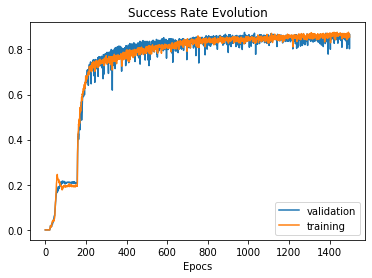

In [253]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

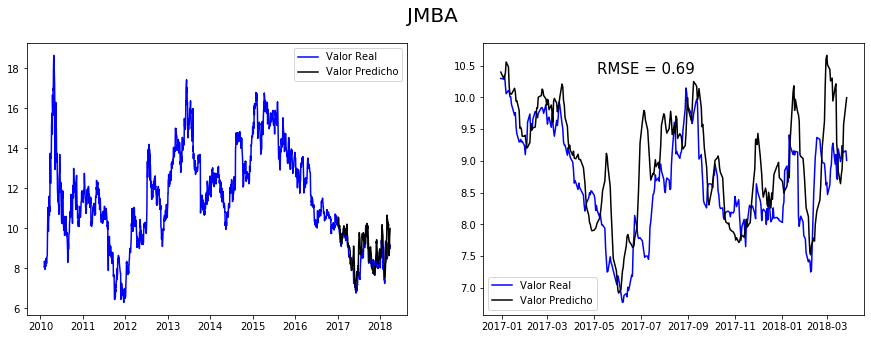

In [261]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Mido el RMSE con 1500 epocas en diferentes modelos, buscamos valores bajos, ambos modelos tanto el de 21 dias como el de 252 dias se haran con una LSTM 4-2
 

| Ticket | 20dias | 240dias|  
|--------|--------|--------|
| SNCR   | 2.67   | 3.24   |  
| EBIO   | 0.14   | 0.17   | 
| MINI   | 1.34   | 1.10   | 
| JBMA   | 0.67   | 0.34   | 
| PTIE   | 0.83   | 1.31   | 

Mido el Porcentaje_margen con 1500 epocas en diferentes modelos, buscamos valores altos, ambos modelos tanto el de 21 dias como el de 240 dias se haran con una LSTM 4-2


| Ticket | 20dias | 240dias|  
|--------|--------|--------|
| SNCR   | 0.81   | 0.79   |  
| EBIO   | 0.50   | 0.40   | 
| MINI   | 0.89   | 0.81   | 
| JBMA   | 0.84   | 0.75   | 
| PTIE   | 0.71   | 0.65   | 


Creo que para estos casos necesito o mas neuronas o mas epocas

RMSE:

| Ticket | 21dias 4-2 | 252dias 4-2|252dias 16-8|252dias 10-5|  
|--------|------------|------------|------------|------------|
| SNCR   | 2.67       | 3.24       |   6.10     |   2.25     |
| EBIO   | 0.14       | 0.17       |   0.32     |   0.28     | 
| MINI   | 1.34       | 1.10       |    1.68    |   1.49     | 
| JBMA   | 0.67       | 0.34       |   0.56     |   0.54     |
| PTIE   | 0.83       | 1.31       |    0.78    |   0.81     |


Solo con 240 dias y diferentes modelos de Red Neuronal

| Ticket | 21dias 4-2 | 252dias 4-2|252dias 16-8|252dias 10-5| 
|--------|------------|------------|------------|------------|
| SNCR   | 0.81       | 0.79       |   0.86     |   0.88     |
| EBIO   | 0.50       | 0.40       |    0.56    |   0.50     | 
| MINI   | 0.89       | 0.81       |    0.88    |   0.90     |
| JBMA   | 0.84       | 0.75       |   0.90     |   0.90     | 
| PTIE   | 0.71       | 0.65       |    0.75    |   0.76     |





Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [257]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.0005
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({-1.0: 160, 1.0: 145, 0.0: 4})


In [262]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado valor     pred dif
2018-03-26        4.26    10450      0  9.16  9.90301   1
Valor Final = 95726.26
Ganancia con margen = -4273.74


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [263]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado valor     pred dif
2018-03-26         1.7    10303             0      0  9.16  9.90301   1
Valor Final = 94377.18
Ganancia con margen = -5622.82


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [264]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado valor     pred dif
2018-03-26       98687        0             0      1  9.16  9.90301   1
Valor Final = 98687.01
Ganancia con margen = -1312.99


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  